## Lab context 🧪

Fine-tuning updates all the parameters of a pretrained model to adapt it for a specific task, offering high accuracy but requiring significant computational resources and memory. In contrast, LoRA (Low-Rank Adaptation) is a parameter efficient fine-Tuning (PEFT)technique that introduces small trainable matrices into certain layers, allowing most of the original model parameters to remain unchanged. This approach drastically reduces memory and compute requirements, making LoRA much faster and more efficient than full finetuning, especially for large language models, while still achieving comparable performance on many tasks 
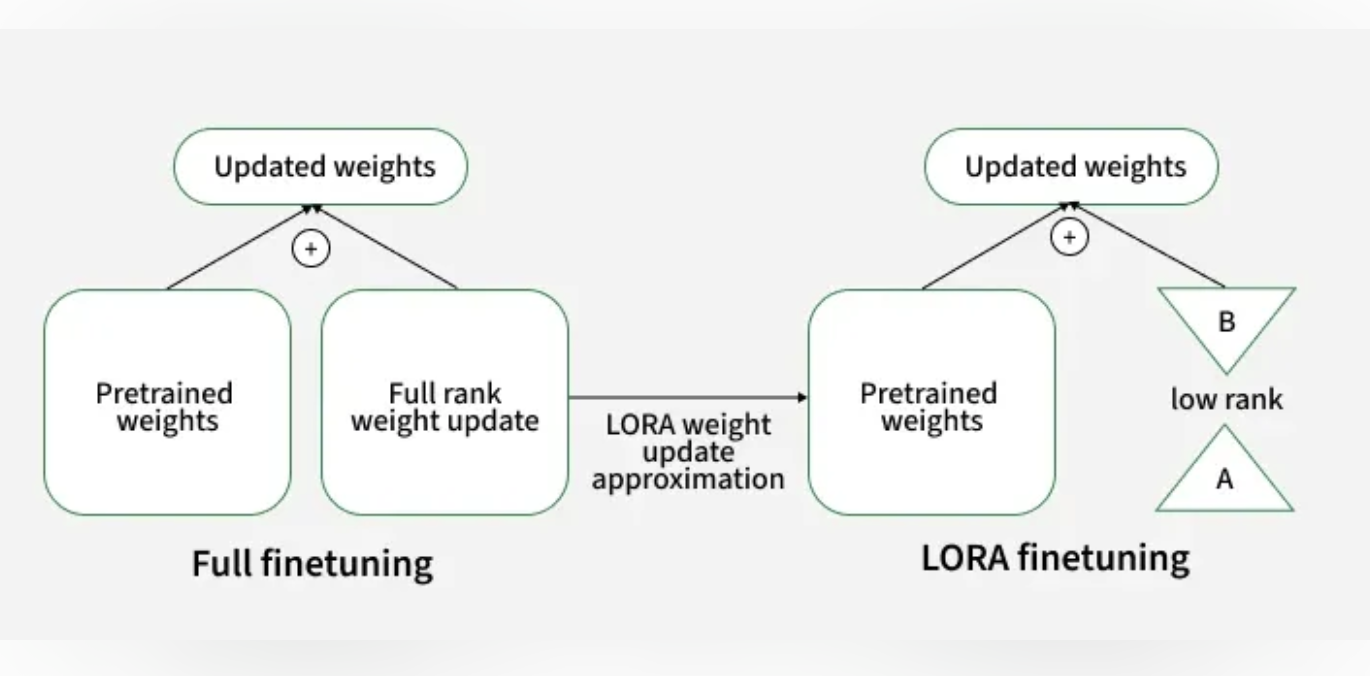

In this notebook we will see how to use lORA to finetune google/flan-t5-small Modal for the task of summarization 


In [ ]:
# Step 1 install required packages
!pip install datasets
!pip install transformers
!pip install evaluate
!pip install accelerate - U
!pip install transformers[torch]
!pip install peft

In [ ]:
# Step 2 Set Up Environment
import torch
device = "mps" if torch.backends.mps.is_available() else "cpu"

from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, TrainingArguments, Trainer, GenerationConfig
import evaluate
import pandas as pd
import numpy as np

In [15]:
# Step 3: Load Dataset
huggingface_dataset_name = "knkarthick/dialogsum"
dataset = load_dataset(huggingface_dataset_name)


In [9]:
# Step 4 Load Pre-trained Model and Tokenizer
model_name = "google/flan-t5-small"
base_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# Step 5 Check Trainable Parameters
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(base_model))

In [ ]:
# Step 6 Perform Baseline Inference
i = 20
dialogue = dataset['test'][i]['dialogue']
summary = dataset['test'][i]['summary']

prompt = f"Summarize the following dialogue  {dialogue}  Summary:"

input_ids = tokenizer(prompt, return_tensors="pt").input_ids
output = tokenizer.decode(base_model.generate(input_ids, max_new_tokens=200)[0], skip_special_tokens=True)

print(f"Input Prompt : {prompt}")
print("--------------------------------------------------------------------")
print("Human evaluated summary ---->")
print(summary)
print("---------------------------------------------------------------------")
print("Baseline model generated summary : ---->")
print(output)
print("---------------------------------------------------------------------")
print("output = ", output)

In [ ]:
# Step 7: Tokenize Dataset
def tokenize_function(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids
    return example

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary'])
tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)

In [ ]:
# Step 8 Apply PEFT with LoRA Configuration
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=4,
    lora_alpha=32,
    lora_dropout=0.1,
)

peft_model_train = get_peft_model(base_model, lora_config)
print(print_number_of_trainable_model_parameters(peft_model_train))

In [20]:
# Step 9 define Training Arguments
output_dir = "./peft-dialogue-summary-training"

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3,
    num_train_epochs=5,
    per_device_train_batch_size=1,
)

In [ ]:
# Step 10 Train the Model
peft_trainer = Trainer(
    model=peft_model_train,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
)

peft_trainer.train()

In [ ]:
# Step 11 Save the Fine-Tuned Model
peft_model_path = "./peft-dialogue-summary-checkpoint-local"
peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

In [ ]:
# Step 12 Load and Test Fine-Tuned Model
from peft import PeftModel

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")
peft_model = PeftModel.from_pretrained(peft_model_base, peft_model_path, is_trainable=False)

peft_model_outputs = peft_model.generate(input_ids=input_ids, 
                                         generation_config=GenerationConfig(
                                             max_new_tokens=200, 
                                             num_beams=1,
                                             #temperature=1.0,
                                             #top_p=0.9,
                                             ))
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

print(f"Input Prompt : {prompt}")
print("--------------------------------------------------------------------")
print("Human evaluated summary ---->")
print(summary)
print("---------------------------------------------------------------------")
print("Baseline model generated summary : ---->")
print(output)
print("---------------------------------------------------------------------")
print("Peft model generated summary : ---->")
print(peft_model_text_output)